# Project 2 : Real or Not? NLP with Disaster Tweets













In this project based on a kaggle competition, we were challenged to establish a Machine learning model to predict which tweets are about a real disaster or which are not.
This notebook shows the different techniques we used to accomplish this challenge as well as our ranking on kaggle.

**Link of the video :** https://youtu.be/b3N_gA2trUA


**Link of the Github repo :** https://github.com/yassinhediger/fakenewsdetection

**Our Kaggle rank :**

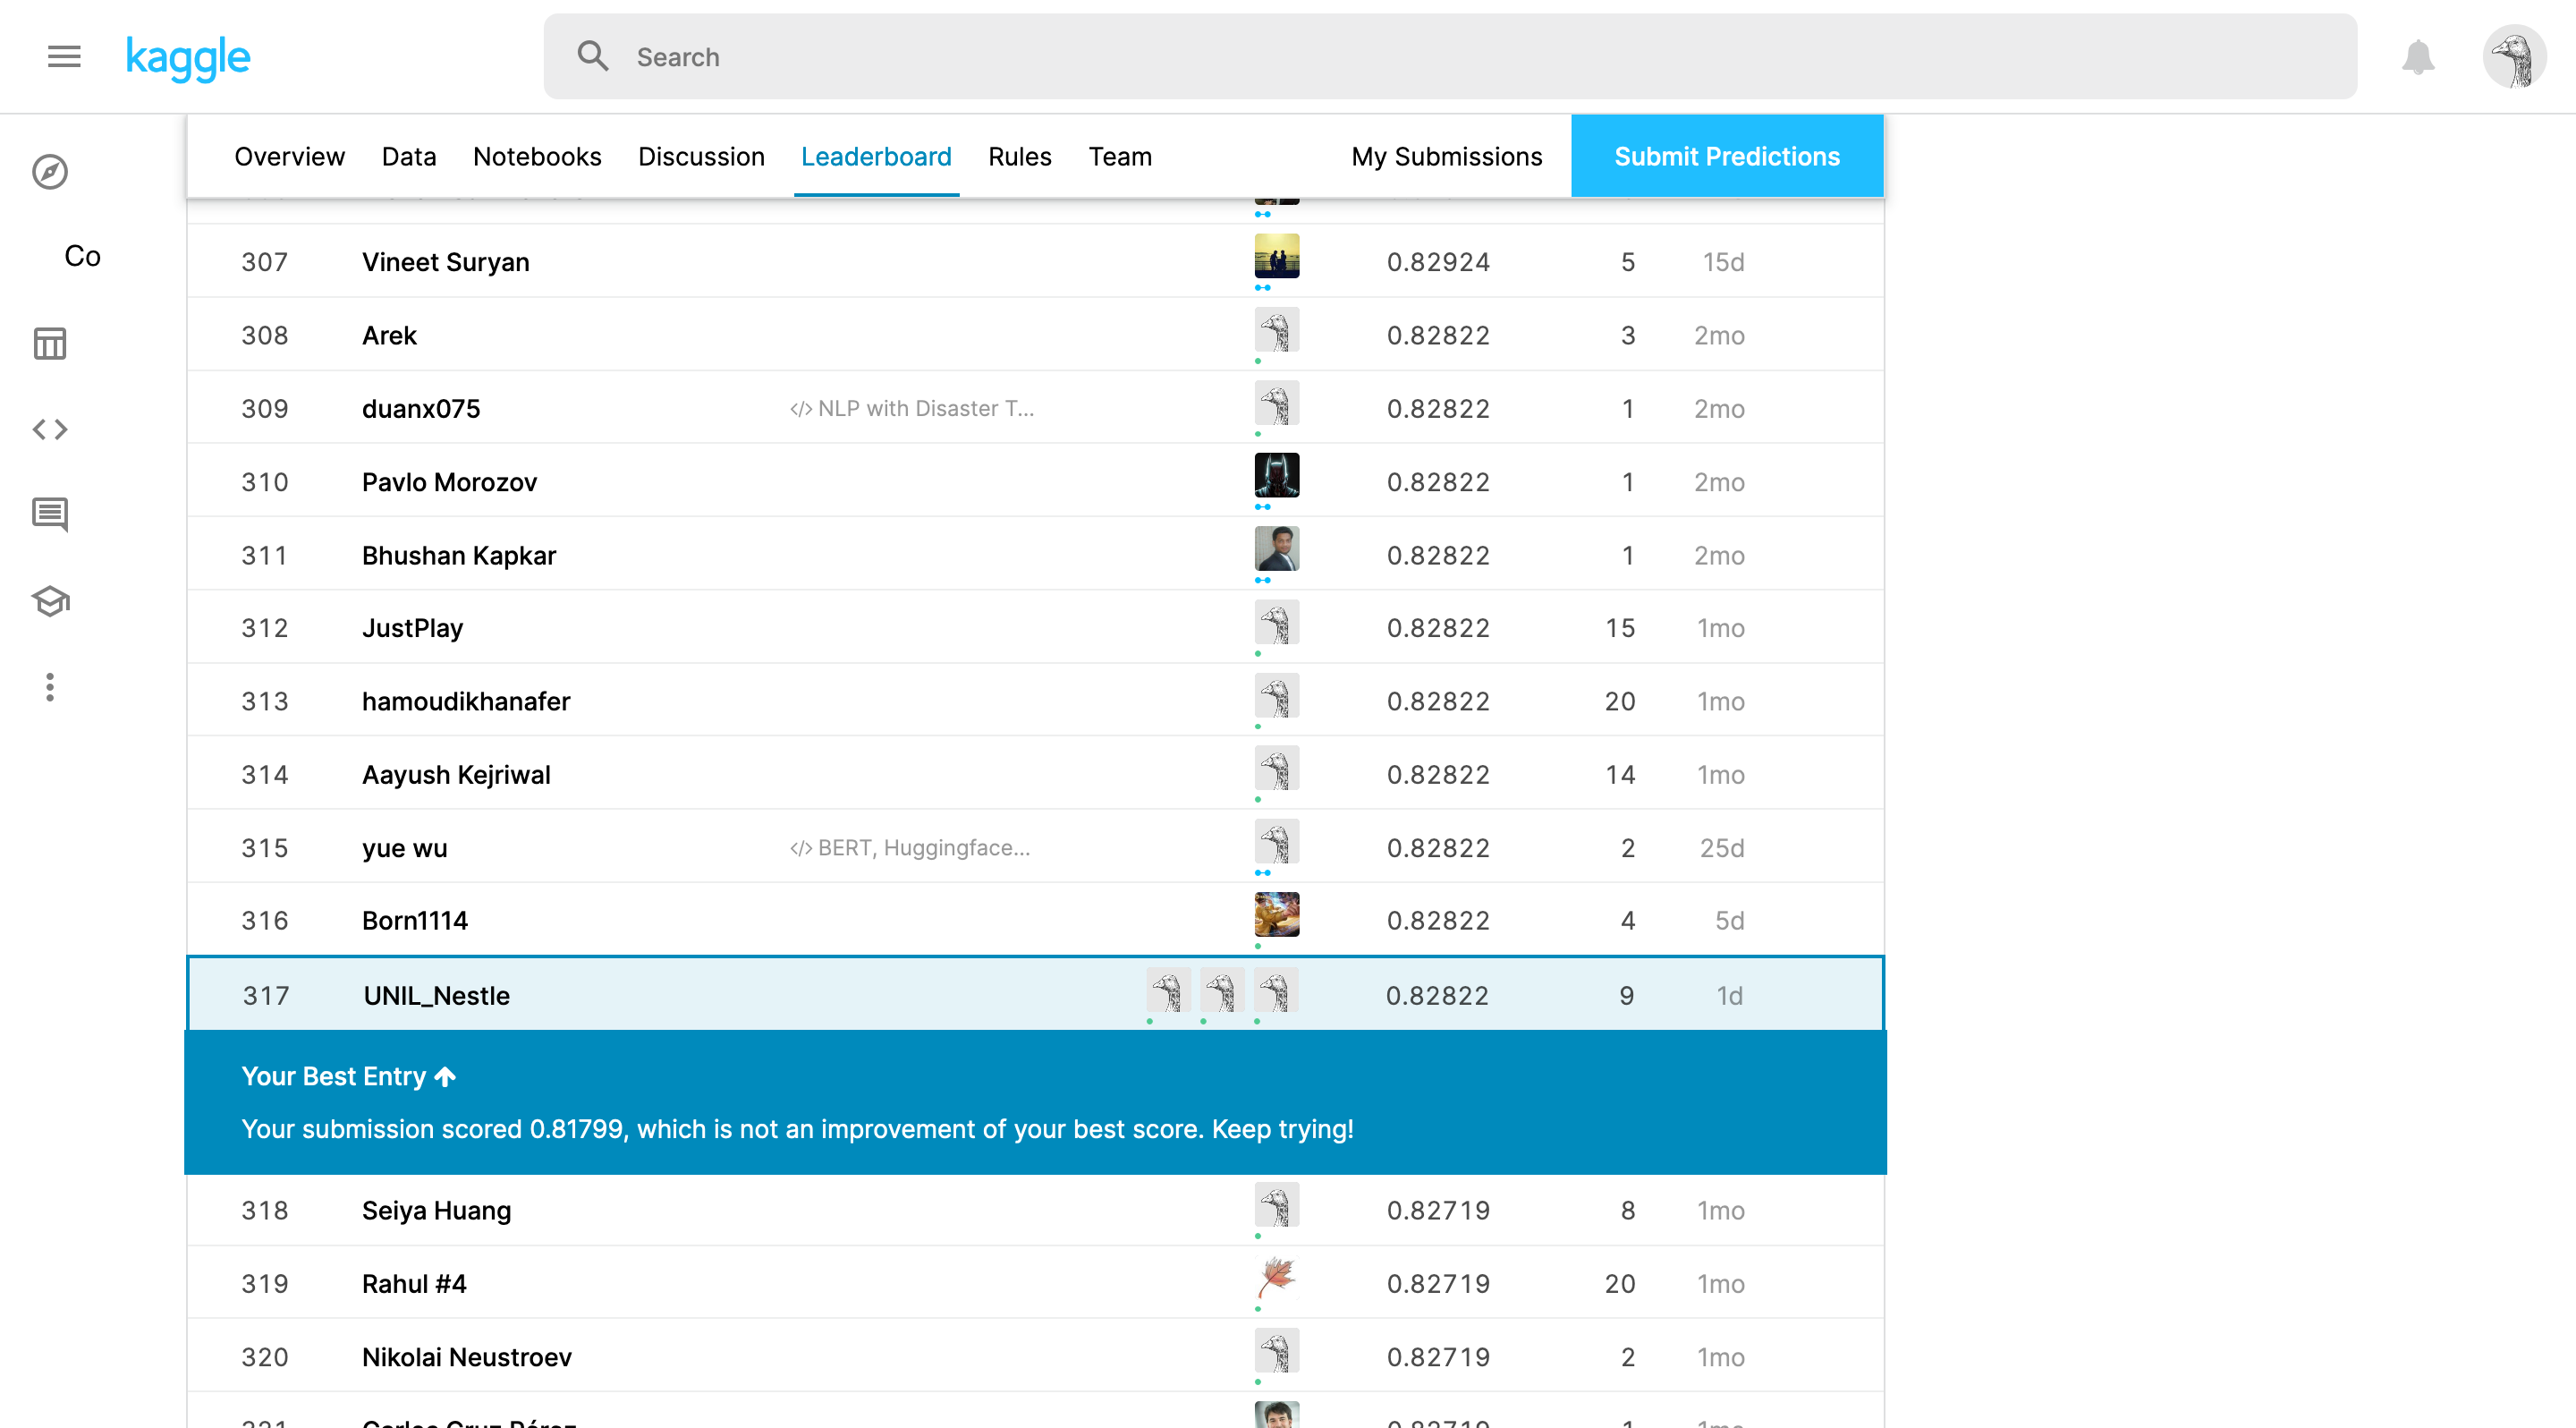

## 1. Importing the libraries

In [0]:
#import of important libraries
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Importing the data

In [0]:
#import train and test data sets
train_df = pd.read_csv("https://raw.githubusercontent.com/yassinhediger/fakenewsdetection/master/data/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/yassinhediger/fakenewsdetection/master/data/test.csv")

In [0]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [0]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## 3. EDA

Let's get some informations about the datasets

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [0]:
#Missing values in training set
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [0]:
#Missing values in test set
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

A lot of values are missing in both train and test set but it won't affect us as we are mainly going to work with the "text" column

### Exploring the target column



Let's see the distribution of the target column



In [0]:
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

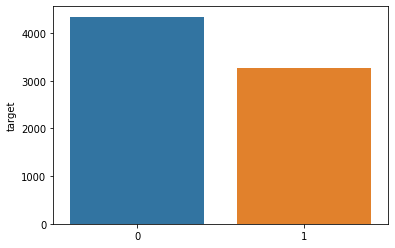

In [0]:
#let's visualize the distribution of target value 
sns.barplot(train_df['target'].value_counts().index,train_df['target'].value_counts())



*   Exploring the Target Column :  Let's look at what the disaster and the non disaster tweets look like



In [0]:
# A disaster tweet
disaster_tweets = train_df[train_df['target']==1]['text']
disaster_tweets.values[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [0]:
#not a disaster tweet
non_disaster_tweets = train_df[train_df['target']==0]['text']
non_disaster_tweets.values[0]

"What's up man?"


### Exploring the 'keyword' column

The keyword column contains a keyword from the tweet. Let's look at the top keywords in the training data


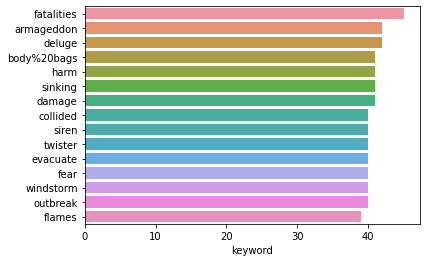

In [0]:
sns.barplot(y=train_df['keyword'].value_counts()[:15].index,x=train_df['keyword'].value_counts()[:15],
            orient='h')

### Common stopwords and punctuation

Let's look at the common stopwords and punctuation for disaster and non-disaster tweets.

In [0]:
stopw = set(stopwords.words('english'))

we need to create a corpus for disaster and non-disaster tweets.

In [0]:
#target will be either 1 ou 0
def create_corpus(target):
    corpus=[]
    
    for x in train_df[train_df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

In [0]:
disaster_corpus = create_corpus(1)
non_disaster_corpus = create_corpus(0)

In [0]:
from collections import defaultdict, Counter
import warnings
import re
import random 

dic_disaster=defaultdict(int)
for word in disaster_corpus:
    if word in stopw:
        dic_disaster[word]+=1
        
dic_non_disaster=defaultdict(int)
for word in non_disaster_corpus:
    if word in stopw:
        dic_non_disaster[word]+=1 

In [0]:
top_disaster = sorted(dic_disaster.items(), key=lambda x:x[1],reverse=True)[:10] 
top_non_disaster = sorted(dic_non_disaster.items(), key=lambda x:x[1],reverse=True)[:10] 

In [0]:
x1,y1=zip(*top_disaster)
x2,y2=zip(*top_non_disaster)
top_stop = pd.DataFrame({'Target':[1]*10+[0]*10, 'Word': [x for x in x1]+[x for x in x2], 'Occurances': [y for y in y1]+[y for y in y2] })

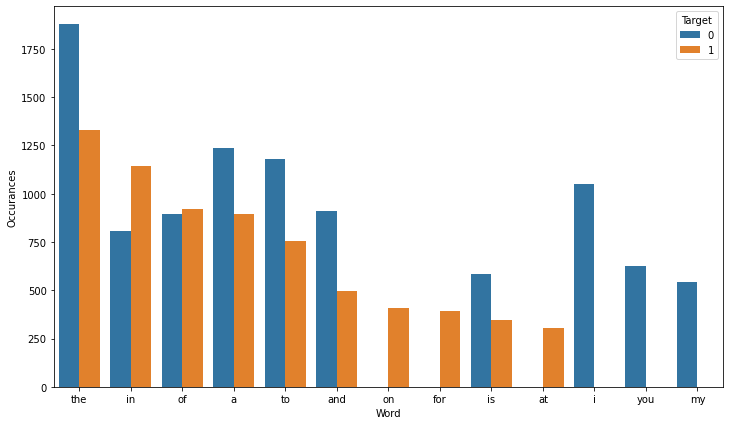

In [0]:
plt.figure(figsize=(12,7))
sns.barplot(x='Word',y='Occurances',data = top_stop,hue='Target')

We can see on the plot above the most common words and their occurances.We will have to do some cleaning here.

Now, let's see about the punctuation.



In [0]:
import string
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
dic_disaster_punct=defaultdict(int)
for word in disaster_corpus:
    if word in punctuation:
        dic_disaster_punct[word]+=1
        
dic_non_disaster_punct=defaultdict(int)
for word in non_disaster_corpus:
    if word in punctuation:
        dic_non_disaster_punct[word]+=1 

In [0]:
top_disaster_punct = sorted(dic_disaster_punct.items(), key=lambda x:x[1],reverse=True)[:10] 
top_non_disaster_punct = sorted(dic_non_disaster_punct.items(), key=lambda x:x[1],reverse=True)[:10]

In [0]:
x1,y1=zip(*top_disaster_punct)
x2,y2=zip(*top_non_disaster_punct)
top_punct = pd.DataFrame({'Target':[1]*10+[0]*10, 'Word': [x for x in x1]+[x for x in x2], 'Occurances': [y for y in y1]+[y for y in y2] })

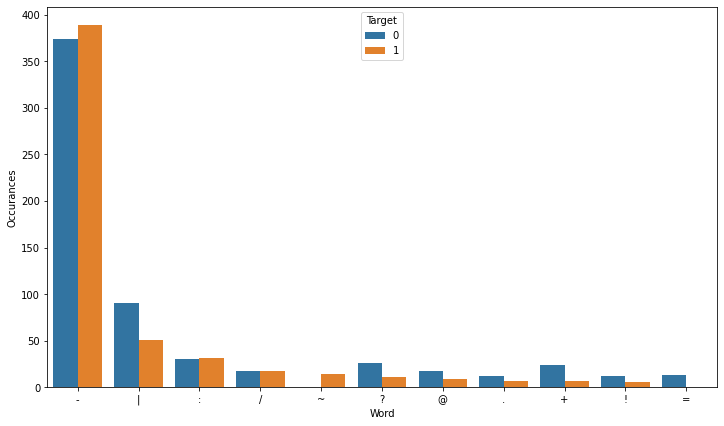

In [0]:
plt.figure(figsize=(12,7))
sns.barplot(x='Word',y='Occurances',data = top_punct,hue='Target')

We can see on the plot above the punctuation and their occurances.We need to do some cleaning here too.

### Common Words

we can now explore the most common words for each class.

In [0]:
counter_d = Counter(disaster_corpus)
most_disaster_words = counter_d.most_common()
x1=[]
y1=[]
for word,count in most_disaster_words[:50]:
    if (word not in stopw) :
        x1.append(word)
        y1.append(count)
        
counter_nd = Counter(non_disaster_corpus)
most_non_disaster_words = counter_nd.most_common()
x2=[]
y2=[]
for word,count in most_non_disaster_words[:50]:
    if (word not in stopw) :
        x2.append(word)
        y2.append(count) 

Text(0.5, 1.0, 'Not disaster')

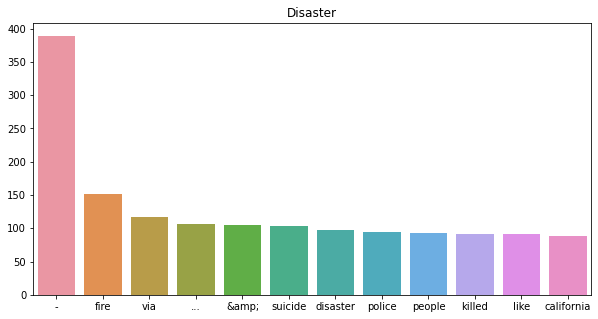

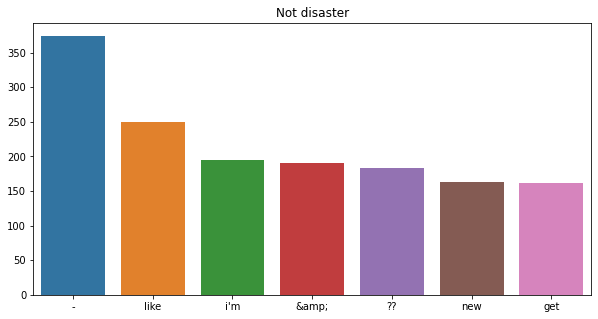

In [0]:
plt.figure(figsize=(10,5))
sns.barplot(x=x1,y=y1)
plt.title('Disaster')
plt.figure(figsize=(10,5))
sns.barplot(x=x2,y=y2)
plt.title('Not disaster')

We can see in plots above that there are some common words that are not actually words, that shows us the we need to remove them from our data.

### N-grams: bigrams and trigrams

n-grams are groups of consecutive characters in a word - i.e. 'mother' has bigrams mo, ot, th, he, er and trigrams mot, oth, the and her OR consecutive n-groups of words in a text - i.e. 'This is my text' would become 'this is', 'is my' and 'my text'. This is the traditional way of analysing text data and performing NLP

Let's start with Most common bigrams (n = 2)

In [0]:
def generate_ngrams(text, n):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stopw]
    ngrams = zip(*[token[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

In [0]:
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train_df[train_df['target']==1]['text']:
    for word in generate_ngrams(tweet,2):
        disaster_bigrams[word] += 1
        
for tweet in train_df[train_df['target']==0]['text']:
    for word in generate_ngrams(tweet,2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1],columns=['bigrams','frequency'])

df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1],columns=['bigrams','frequency'])        

In [0]:
df_disaster_bigrams.head()

,bigrams,frequency
0,suicide bomber,59
1,northern california,40
2,oil spill,37
3,california wildfire,31
4,bomber detonated,30


Let's visualize the bigrams 

Text(0.5, 1.0, 'Common bigrams - Not Disaster')

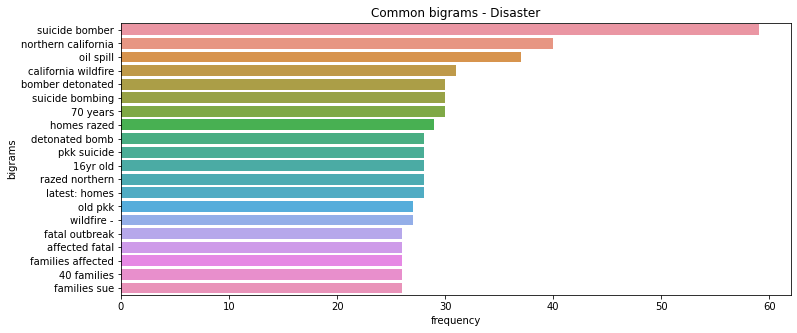

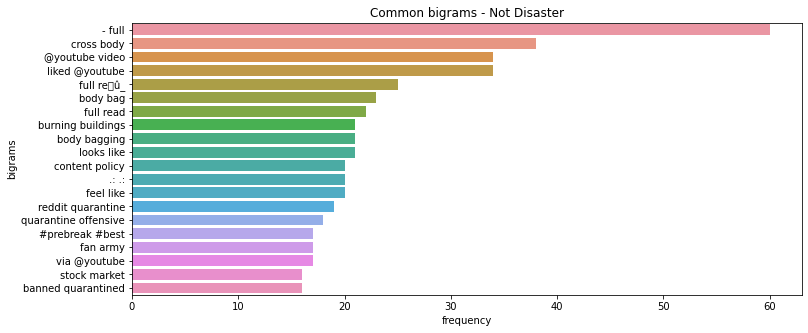

In [0]:
plt.figure(figsize = (12,5))
sns.barplot(y='bigrams',x='frequency', data=df_disaster_bigrams[:20])
plt.title('Common bigrams - Disaster')

plt.figure(figsize = (12,5))
sns.barplot(y='bigrams',x='frequency',data=df_nondisaster_bigrams[:20] )
plt.title('Common bigrams - Not Disaster')

Now the most common trigrams (n=3) and visualize them.

In [0]:
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train_df[train_df['target']==1]['text']:
    for word in generate_ngrams(tweet,3):
        disaster_trigrams[word] += 1
        
for tweet in train_df[train_df['target']==0]['text']:
    for word in generate_ngrams(tweet,3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1],columns=['trigrams','frequency'])

df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1],columns=['trigrams','frequency'])        

Text(0.5, 1.0, 'Common trigrams - Not Disaster')

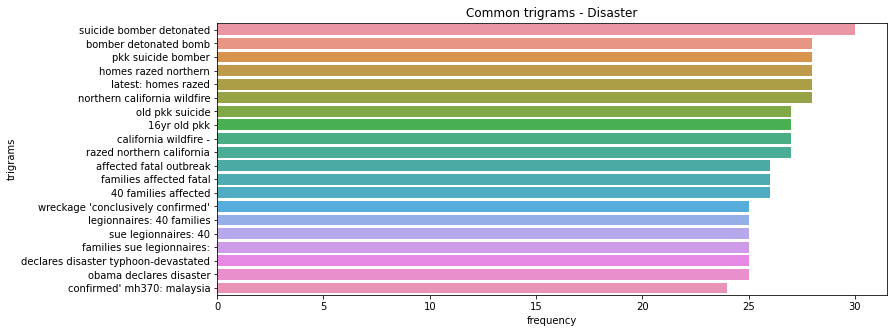

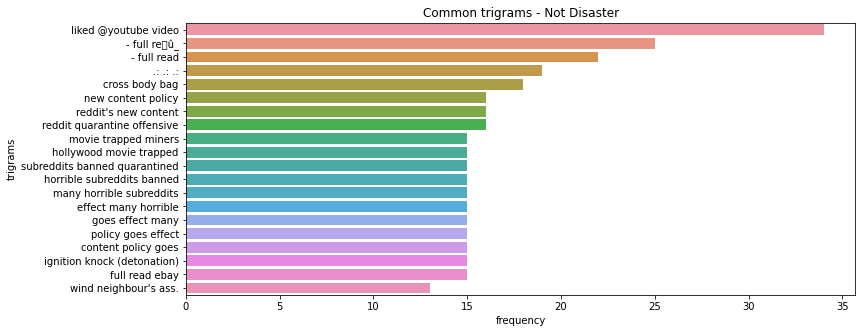

In [0]:
plt.figure(figsize = (12,5))
sns.barplot(y='trigrams',x='frequency', data=df_disaster_trigrams[:20])
plt.title('Common trigrams - Disaster')

plt.figure(figsize = (12,5))
sns.barplot(y='trigrams',x='frequency',data=df_nondisaster_trigrams[:20] )
plt.title('Common trigrams - Not Disaster')

It seems that the text is not clean and if we take a clearer look into the individual texts we notice that they contain URLs, weird abbreviations, emojis, @ and #'s, so the next task is to clean the text and then compute the n-grams again.

## 4. Cleaning data process



### 4.1 Removing URLs

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [0]:
#Let's use our remove_url function and apply it to our data
train_df['text'] = train_df['text'].apply(lambda x : remove_URL(x))

### 4.2 Removing HTMLs

In [0]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [0]:
#Let's use our remove_html function and apply it to our data
train_df['text'] = train_df["text"].apply(lambda x: remove_html(x))

### 4.3 Removing emojis

In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [0]:
#Let's use our remove_emoji function and apply it to our data
train_df['text'] = train_df["text"].apply(lambda x: remove_emoji(x))

### 4.4 Removing punctuations

In [0]:
def remove_punctuation(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [0]:
#Let's use our remove_punctuation function and apply it to our data
train_df['text'] = train_df["text"].apply(lambda x: remove_punctuation(x))

### 4.5 Removing contraction

In [0]:
def remove_contractions(text):
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)  
    text = re.sub(r"donå«t", "do not", text)   
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&amp;", "&", text)
    return text



In [0]:
train_df['text'] = train_df["text"].apply(lambda x: remove_contractions(x))

### 4.6 Removing abbreviations

In [0]:

def remove_abreviations(sentence):
    for text in sentence.split():
    
        text = re.sub(r"$" , " dollar ", text)
        text = re.sub(r"€" , " euro ", text)
        text = re.sub(r"4ao" , "for adults only", text)
        text = re.sub(r"a.m" , "before midday", text)
        text = re.sub(r"a3" , "anytime anywhere anyplace", text)
        text = re.sub(r"aamof" , "as a matter of fact", text)
        text = re.sub(r"acct" , "account", text)
        text = re.sub(r"adih" , "another day in hell", text)
        text = re.sub(r"afaic" , "as far as i am concerned", text)
        text = re.sub(r"afaict" , "as far as i can tell", text)
        text = re.sub(r"afaik" , "as far as i know", text)
        text = re.sub(r"afair" , "as far as i remember", text)
        text = re.sub(r"afk" , "away from keyboard", text)
        text = re.sub(r"app" , "application", text)
        text = re.sub(r"approx" , "approximately", text)
        text = re.sub(r"apps" , "applications", text)
        text = re.sub(r"asap" , "as soon as possible", text)
        text = re.sub(r"asl" , "age, sex, location", text)
        text = re.sub(r"atk" , "at the keyboard", text)
        text = re.sub(r"ave." , "avenue", text)
        text = re.sub(r"aymm" , "are you my mother", text)
        text = re.sub(r"ayor" , "at your own risk",  text)
        text = re.sub(r"b&b" , "bed and breakfast", text)
        text = re.sub(r"b+b" , "bed and breakfast", text)
        text = re.sub(r"b.c" , "before christ", text)
        text = re.sub(r"b2b" , "business to business", text)
        text = re.sub(r"b2c" , "business to customer", text)
        text = re.sub(r"b4" , "before", text)
        text = re.sub(r"b4n" , "bye for now", text)
        text = re.sub(r"b@u" , "back at you", text)
        text = re.sub(r"bae" , "before anyone else", text)
        text = re.sub(r"bak" , "back at keyboard", text)
        text = re.sub(r"bbbg" , "bye bye be good", text)
        text = re.sub(r"bbc" , "british broadcasting corporation", text)
        text = re.sub(r"bbias" , "be back in a second", text)
        text = re.sub(r"bbl" , "be back later", text)
        text = re.sub(r"bbs" , "be back soon", text)
        text = re.sub(r"be4" , "before", text)
        text = re.sub(r"bfn" , "bye for now", text)
        text = re.sub(r"blvd" , "boulevard", text)
        text = re.sub(r"bout" , "about", text)
        text = re.sub(r"brb" , "be right back", text)
        text = re.sub(r"bros" , "brothers", text)
        text = re.sub(r"brt" , "be right there", text)
        text = re.sub(r"bsaaw" , "big smile and a wink", text)
        text = re.sub(r"btw" , "by the way", text)
        text = re.sub(r"bwl" , "bursting with laughter", text)
        text = re.sub(r"c/o" , "care of", text)
        text = re.sub(r"cet" , "central european time", text)
        text = re.sub(r"cf" , "compare", text)
        text = re.sub(r"cia" , "central intelligence agency", text)
        text = re.sub(r"csl" , "can not stop laughing", text)
        text = re.sub(r"cu" , "see you", text)
        text = re.sub(r"cul8r" , "see you later", text)
        text = re.sub(r"cv" , "curriculum vitae", text)
        text = re.sub(r"cwot" , "complete waste of time", text)
        text = re.sub(r"cya" , "see you", text)
        text = re.sub(r"cyt" , "see you tomorrow", text)
        text = re.sub(r"dae" , "does anyone else", text)
        text = re.sub(r"dbmib" , "do not bother me i am busy", text)
        text = re.sub(r"diy" , "do it yourself", text)
        text = re.sub(r"dm" , "direct message", text)
        text = re.sub(r"dwh" , "during work hours", text)
        text = re.sub(r"e123" , "easy as one two three", text)
        text = re.sub(r"eet" , "eastern european time", text)
        text = re.sub(r"eg" , "example", text)
        text = re.sub(r"embm" , "early morning business meeting", text)
        text = re.sub(r"encl" , "enclosed", text)
        text = re.sub(r"encl." , "enclosed", text)
        text = re.sub(r"etc" , "and so on", text)
        text = re.sub(r"faq" , "frequently asked questions", text)
        text = re.sub(r"fawc" , "for anyone who cares", text)
        text = re.sub(r"fb" , "facebook", text)
        text = re.sub(r"fc" , "fingers crossed", text)
        text = re.sub(r"fig" , "figure", text)
        text = re.sub(r"fimh" , "forever in my heart",  text)
        text = re.sub(r"ft." , "feet", text)
        text = re.sub(r"ft" , "featuring", text)
        text = re.sub(r"ftl" , "for the loss", text)
        text = re.sub(r"ftw" , "for the win", text)
        text = re.sub(r"fwiw" , "for what it is worth", text)
        text = re.sub(r"fyi" , "for your information", text)
        text = re.sub(r"g9" , "genius", text)
        text = re.sub(r"gahoy" , "get a hold of yourself", text)
        text = re.sub(r"gal" , "get a life", text)
        text = re.sub(r"gcse" , "general certificate of secondary education", text)
        text = re.sub(r"gfn" , "gone for now", text)
        text = re.sub(r"gg" , "good game",  text)
        text = re.sub(r"gl" , "good luck", text)
        text = re.sub(r"glhf" , "good luck have fun", text)
        text = re.sub(r"gmt" , "greenwich mean time", text)
        text = re.sub(r"gmta" , "great minds think alike", text)
        text = re.sub(r"gn" , "good night", text)
        text = re.sub(r"g.o.a.t" , "greatest of all time", text)
        text = re.sub(r"goat" , "greatest of all time", text)
        text = re.sub(r"goi" , "get over it", text)
        text = re.sub(r"gps" , "global positioning system", text)
        text = re.sub(r"gr8" , "great", text)
        text = re.sub(r"gratz" , "congratulations", text)
        text = re.sub(r"gyal" , "girl", text)
        text = re.sub(r"h&c" , "hot and cold", text)
        text = re.sub(r"hp" , "horsepower", text)
        text = re.sub(r"hr" , "hour", text)
        text = re.sub(r"hrh" , "his royal highness", text)
        text = re.sub(r"ht" , "height", text)
        text = re.sub(r"ibrb" , "i will be right back", text)
        text = re.sub(r"ic" , "i see", text)
        text = re.sub(r"icq" , "i seek you", text)
        text = re.sub(r"icymi" , "in case you missed it", text)
        text = re.sub(r"idc" , "i do not care", text)
        text = re.sub(r"idgadf" , "i do not give a damn fuck", text)
        text = re.sub(r"idgaf" , "i do not give a fuck", text)
        text = re.sub(r"idk" , "i do not know", text)
        text = re.sub(r"ie" , "that is", text)
        text = re.sub(r"i.e" , "that is", text)
        text = re.sub(r"ifyp" , "i feel your pain", text)
        text = re.sub(r"IG" , "instagram", text)
        text = re.sub(r"iirc" , "if i remember correctly", text)
        text = re.sub(r"ilu" , "i love you", text)
        text = re.sub(r"ily" , "i love you", text)
        text = re.sub(r"imho" , "in my humble opinion", text)
        text = re.sub(r"imo" , "in my opinion", text)
        text = re.sub(r"imu" , "i miss you", text)
        text = re.sub(r"iow" , "in other words", text)
        text = re.sub(r"irl" , "in real life", text)
        text = re.sub(r"j4f" , "just for fun", text)
        text = re.sub(r"jic" , "just in case", text)
        text = re.sub(r"jk" , "just kidding", text)
        text = re.sub(r"jsyk" , "just so you know", text)
        text = re.sub(r"l8r" , "later", text)
        text = re.sub(r"lb" , "pound", text)
        text = re.sub(r"lbs" , "pounds", text)
        text = re.sub(r"ldr" , "long distance relationship", text)
        text = re.sub(r"lmao" , "laugh my ass off", text)
        text = re.sub(r"lmfao" , "laugh my fucking ass off", text)
        text = re.sub(r"lol" , "laughing out loud", text)
        text = re.sub(r"ltd" , "limited", text)
        text = re.sub(r"ltns" , "long time no see", text)
        text = re.sub(r"m8" , "mate", text)
        text = re.sub(r"mf" , "motherfucker", text)
        text = re.sub(r"mfs" , "motherfuckers", text)
        text = re.sub(r"mfw" , "my face when", text)
        text = re.sub(r"mofo" , "motherfucker", text)
        text = re.sub(r"mph" , "miles per hour", text)
        text = re.sub(r"mr" , "mister", text)
        text = re.sub(r"mrw" , "my reaction when", text)
        text = re.sub(r"ms" , "miss", text)
        text = re.sub(r"mte" , "my thoughts exactly", text)
        text = re.sub(r"nagi" , "not a good idea", text)
        text = re.sub(r"nbc" , "national broadcasting company", text)
        text = re.sub(r"nbd" , "not big deal", text)
        text = re.sub(r"nfs" , "not for sale", text)
        text = re.sub(r"ngl" , "not going to lie", text)
        text = re.sub(r"nhs" , "national health service", text)
        text = re.sub(r"nrn" , "no reply necessary", text)
        text = re.sub(r"nsfl" , "not safe for life", text)
        text = re.sub(r"nsfw" , "not safe for work", text)
        text = re.sub(r"nth" , "nice to have", text)
        text = re.sub(r"nvr" , "never", text)
        text = re.sub(r"nyc" , "new york city", text)
        text = re.sub(r"oc" , "original content", text)
        text = re.sub(r"og" , "original", text)
        text = re.sub(r"ohp" , "overhead projector", text)
        text = re.sub(r"oic" , "oh i see", text)
        text = re.sub(r"omdb" , "over my dead body", text)
        text = re.sub(r"omg" , "oh my god", text)
        text = re.sub(r"omw" , "on my way", text)
        text = re.sub(r"p.a" , "per annum", text)
        text = re.sub(r"p.m" , "after midday", text)
        text = re.sub(r"pm" , "prime minister", text)
        text = re.sub(r"poc" , "people of color", text)
        text = re.sub(r"pov" , "point of view", text)
        text = re.sub(r"pp" , "pages", text)
        text = re.sub(r"ppl" , "people", text)
        text = re.sub(r"prw" , "parents are watching", text)
        text = re.sub(r"ps" , "postscript", text)
        text = re.sub(r"pt" , "point", text)
        text = re.sub(r"ptb" , "please text back", text)
        text = re.sub(r"pto" , "please turn over", text)
        text = re.sub(r"qpsa" , "what happens", text)
        text = re.sub(r"ratchet" , "rude", text)
        text = re.sub(r"rbtl" , "read between the lines", text)
        text = re.sub(r"rlrt" , "real life retweet",  text)
        text = re.sub(r"rofl" , "rolling on the floor laughing", text)
        text = re.sub(r"roflol" , "rolling on the floor laughing out loud", text)
        text = re.sub(r"rotflmao" , "rolling on the floor laughing my ass off", text)
        text = re.sub(r"rt" , "retweet", text)
        text = re.sub(r"ruok" , "are you ok", text)
        text = re.sub(r"sfw" , "safe for work", text)
        text = re.sub(r"sk8" , "skate", text)
        text = re.sub(r"smh" , "shake my head", text)
        text = re.sub(r"sq" , "square", text)
        text = re.sub(r"srsly" , "seriously",  text)
        text = re.sub(r"ssdd" , "same stuff different day", text)
        text = re.sub(r"tbh" , "to be honest", text)
        text = re.sub(r"tbs" , "tablespooful", text)
        text = re.sub(r"tbsp" , "tablespooful", text)
        text = re.sub(r"tfw" , "that feeling when", text)
        text = re.sub(r"thks" , "thank you", text)
        text = re.sub(r"tho" , "though", text)
        text = re.sub(r"thx" , "thank you", text)
        text = re.sub(r"tia" , "thanks in advance", text)
        text = re.sub(r"til" , "today i learned", text)
        text = re.sub(r"tl;dr" , "too long i did not read", text)
        text = re.sub(r"tldr" , "too long i did not read", text)
        text = re.sub(r"tmb" , "tweet me back", text)
        text = re.sub(r"tntl" , "trying not to laugh", text)
        text = re.sub(r"ttyl" , "talk to you later", text)
        text = re.sub(r"u" , "you", text)
        text = re.sub(r"u2" , "you too", text)
        text = re.sub(r"u4e" , "yours for ever", text)
        text = re.sub(r"utc" , "coordinated universal time", text)
        text = re.sub(r"w/" , "with", text)
        text = re.sub(r"w/o" , "without", text)
        text = re.sub(r"w8" , "wait", text)
        text = re.sub(r"wassup" , "what is up", text)
        text = re.sub(r"wb" , "welcome back", text)
        text = re.sub(r"wtf" , "what the fuck", text)
        text = re.sub(r"wtg" , "way to go", text)
        text = re.sub(r"wtpa" , "where the party at", text)
        text = re.sub(r"wuf" , "where are you from", text)
        text = re.sub(r"wuzup" , "what is up", text)
        text = re.sub(r"wywh" , "wish you were here", text)
        text = re.sub(r"yd" , "yard", text)
        text = re.sub(r"ygtr" , "you got that right", text)
        text = re.sub(r"ynk" , "you never know", text)
        text = re.sub(r"zzz" , "sleeping bored and tired", text)


    return sentence



In [0]:
train_df['text'] = train_df["text"].apply(lambda x: remove_abreviations(x))

### 4.7 Removing acronyms

In [0]:
def remove_acronyms(text):
    text = re.sub(r"MH370", "Malaysia Airlines Flight 370", text)
    text = re.sub(r"mÌ¼sica", "music", text)
    text = re.sub(r"okwx", "Oklahoma City Weather", text)
    text = re.sub(r"arwx", "Arkansas Weather", text)    
    text = re.sub(r"gawx", "Georgia Weather", text)  
    text = re.sub(r"scwx", "South Carolina Weather", text)  
    text = re.sub(r"cawx", "California Weather", text)
    text = re.sub(r"tnwx", "Tennessee Weather", text)
    text = re.sub(r"azwx", "Arizona Weather", text)  
    text = re.sub(r"alwx", "Alabama Weather", text)
    text = re.sub(r"wordpressdotcom", "wordpress", text)    
    text = re.sub(r"usNWSgov", "United States National Weather Service", text)
    text = re.sub(r"Suruc", "Sanliurfa", text)  
    
    return text

In [0]:
train_df['text'] = train_df["text"].apply(lambda x: remove_acronyms(x))

### 4.8 Further cleaning

In [0]:
# Applying a first round of text cleaning techniques

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [0]:
# Applying the clean_text function to our dataset
train_df['text'] = train_df['text'].apply(lambda x: clean_text(x))

In [0]:
# A quick glance over the existing data
train_df['text'][:20]

0     our deeds are the reason of this earthquake ma...
1                 forest fire near la ronge sask canada
2     all residents asked to shelter in place are be...
3      people receive wildfires evacuation orders in...
4     just got sent this photo from ruby alaska as s...
5     rockyfire update  california hwy  closed in bo...
6     flood disaster heavy rain causes flash floodin...
7     im on top of the hill and i can see a fire in ...
8     theres an emergency evacuation happening now i...
9      im afraid that the tornado is coming to our area
10          three people died from the heat wave so far
11    haha south tampa is getting flooded hah wait a...
12    raining flooding florida tampabay tampa  or  d...
13                flood in bago myanmar we arrived bago
14    damage to school bus on  in multi car crash br...
15                                         whats up man
16                                        i love fruits
17                                     summer is

### 4.9 Redo bigrams and trigrams

Now let's compute bigrams and trigrams again with cleaned data

Text(0.5, 1.0, 'Common bigrams - Not Disaster')

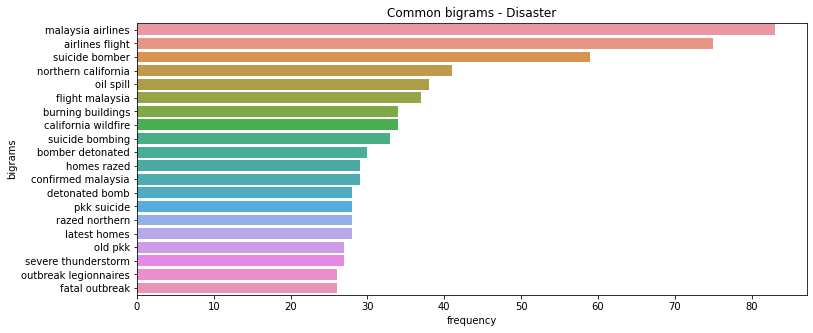

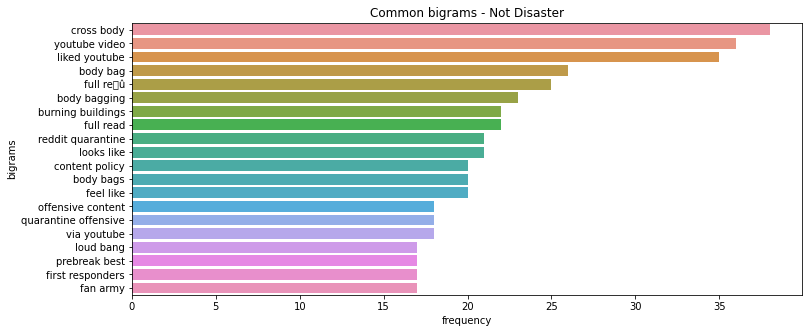

In [0]:
#bigrams (n=2)
cleaned_disaster_bigrams = defaultdict(int)
cleaned_nondisaster_bigrams = defaultdict(int)

for tweet in train_df[train_df['target']==1]['text']:
    for word in generate_ngrams(tweet,2):
        cleaned_disaster_bigrams[word] += 1
        
for tweet in train_df[train_df['target']==0]['text']:
    for word in generate_ngrams(tweet,2):
        cleaned_nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(cleaned_disaster_bigrams.items(), key=lambda x: x[1])[::-1],columns=['bigrams','frequency'])

df_nondisaster_bigrams = pd.DataFrame(sorted(cleaned_nondisaster_bigrams.items(), key=lambda x: x[1])[::-1],columns=['bigrams','frequency'])    

plt.figure(figsize = (12,5))
sns.barplot(y='bigrams',x='frequency', data=df_disaster_bigrams[:20])
plt.title('Common bigrams - Disaster')

plt.figure(figsize = (12,5))
sns.barplot(y='bigrams',x='frequency',data=df_nondisaster_bigrams[:20] )
plt.title('Common bigrams - Not Disaster')

Text(0.5, 1.0, 'Common trigrams - Not Disaster')

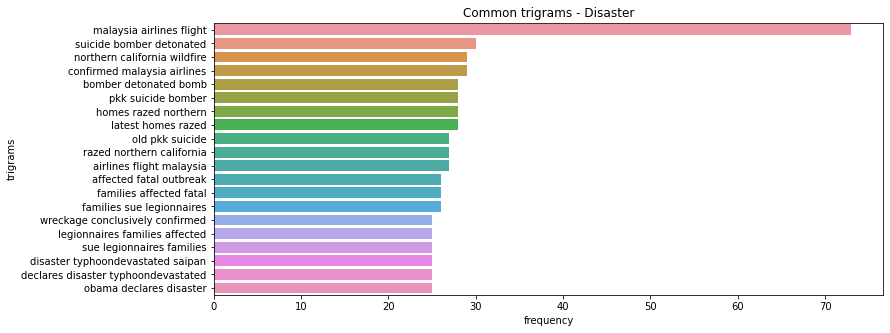

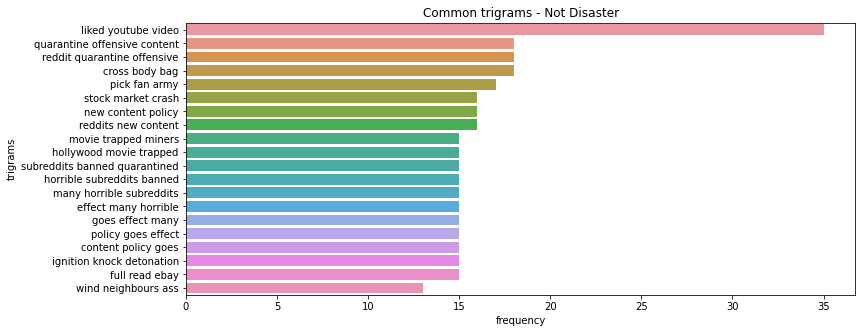

In [0]:
#trigrams (n=3)
cleaned_disaster_trigrams = defaultdict(int)
cleaned_nondisaster_trigrams = defaultdict(int)

for tweet in train_df[train_df['target']==1]['text']:
    for word in generate_ngrams(tweet,3):
        cleaned_disaster_trigrams[word] += 1
        
for tweet in train_df[train_df['target']==0]['text']:
    for word in generate_ngrams(tweet,3):
        cleaned_nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(cleaned_disaster_trigrams.items(), key=lambda x: x[1])[::-1],columns=['trigrams','frequency'])

df_nondisaster_trigrams = pd.DataFrame(sorted(cleaned_nondisaster_trigrams.items(), key=lambda x: x[1])[::-1],columns=['trigrams','frequency'])    

plt.figure(figsize = (12,5))
sns.barplot(y='trigrams',x='frequency', data=df_disaster_trigrams[:20])
plt.title('Common trigrams - Disaster')

plt.figure(figsize = (12,5))
sns.barplot(y='trigrams',x='frequency',data=df_nondisaster_trigrams[:20] )
plt.title('Common trigrams - Not Disaster')

We can see that the text is clean now.

## 5. Building a model to predict disaster tweets



### 5.1 Bag of words and Naive Bayes (multinomialNB) 

A natural way to represent text for computers is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.

Now, as our first type of embedding we will use the vanilla bag of words - basically we will compute a matrix, in which the rows are the documents(tweets), and the columns are the words in our vocabulary, with the cell c(i,j) pointing to tweet i, word j and having a value of 1 if that word appears in that document, and 0 otherwise. For this, we will use CountVectorizer - however, we will use some specific parameters for it to make our life easier:

    

*   lowercase=True --> this will basically lowercase all words
*   stop_words = 'english' --> this will get rid of most common words in english ('the', 'are','I', 'a' etc.) as these would provide litte value in distinguishing wheter a tweet is referring to a disatser or not
* max_df = 0.95 --> this will only keep words that occur up to 95% of the documents, for a similar reason as above
* min_df = 2 --> this will only keep words which occur in at least 2 documents, as otherwise that specific word will be useless in our analysis



In [0]:
count_vectorizer = CountVectorizer(lowercase=True, stop_words='english', max_df=0.95, min_df=2)

In [0]:
X = count_vectorizer.fit_transform(list(train_df['text']))

In [0]:
#let's look at the vocabulary word_name :word_id
count_vectorizer.vocabulary_

{'deeds': 1336,
 'reason': 4233,
 'earthquake': 1603,
 'allah': 136,
 'forgive': 2040,
 'forest': 2036,
 'near': 3499,
 'la': 2883,
 'canada': 758,
 'residents': 4339,
 'asked': 281,
 'shelter': 4678,
 'place': 3901,
 'officers': 3637,
 'evacuation': 1756,
 'orders': 3698,
 'expected': 1798,
 'people': 3824,
 'receive': 4238,
 'wildfires': 5793,
 'california': 738,
 'just': 2796,
 'got': 2217,
 'sent': 4621,
 'photo': 3859,
 'alaska': 124,
 'smoke': 4809,
 'school': 4561,
 'rockyfire': 4435,
 'update': 5542,
 'hwy': 2531,
 'closed': 985,
 'lake': 2893,
 'county': 1165,
 'cafire': 728,
 'flood': 2000,
 'disaster': 1461,
 'heavy': 2395,
 'rain': 4170,
 'causes': 825,
 'flash': 1988,
 'flooding': 2002,
 'streets': 5008,
 'colorado': 1034,
 'springs': 4921,
 'areas': 241,
 'im': 2568,
 'hill': 2433,
 'woods': 5840,
 'theres': 5251,
 'emergency': 1669,
 'happening': 2335,
 'building': 686,
 'street': 5007,
 'afraid': 90,
 'tornado': 5350,
 'coming': 1044,
 'area': 240,
 'died': 1436,
 'heat

In [0]:
#now let's check which are our features and how many of them there are
print(count_vectorizer.get_feature_names())
len(count_vectorizer.get_feature_names())

['aa', 'aba', 'abandon', 'abandoned', 'abbott', 'abbswinston', 'abc', 'abcnews', 'abe', 'abia', 'ability', 'ablaze', 'able', 'abomb', 'abomination', 'abortion', 'absolute', 'absolutely', 'abstorm', 'abuse', 'abused', 'abuseddesolateamplost', 'abusing', 'ac', 'acc', 'accept', 'access', 'accident', 'accidentally', 'accidents', 'accionempresa', 'according', 'account', 'accounts', 'accused', 'accuses', 'accustomed', 'acdelco', 'achimota', 'acid', 'acoustic', 'acquire', 'acquisitions', 'acres', 'act', 'acted', 'acting', 'action', 'actions', 'activated', 'activates', 'active', 'activities', 'activity', 'actor', 'actress', 'acts', 'actual', 'actually', 'acute', 'ad', 'adam', 'add', 'added', 'adding', 'addition', 'address', 'admin', 'administration', 'admit', 'admits', 'adult', 'adults', 'advance', 'advanced', 'adventures', 'advertised', 'advice', 'advised', 'advisory', 'af', 'afc', 'affect', 'affected', 'affecting', 'affects', 'affiliation', 'afghan', 'afghanistan', 'afp', 'afraid', 'africa',

5970

In [0]:
X = X.toarray()

In [0]:
X.shape

(7613, 5970)

Now, we will split our training dataset into train and test, so that we can build our model on the training portion and test on the validation portion.

In [0]:
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=113)

Once we have split our data into train and test set, we will use a Naive Bayes classifier. Naive bayes is a good chocie for a medium-sized dataset and it is traditionally used in NLP.  We are going to use Multinomial NB as it is suitable for classification with discrete features. We will use GridSeachCV to look for optimal alpha for our model, and will use 5 folds for cross-validtion.

In [0]:
#list of alphas we are going to try
alpha_list = np.linspace(1, 100, 100)
alpha_list

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [0]:
parameter_grid = [{"alpha":alpha_list}]

In [0]:
clf= MultinomialNB()
gridsearch = GridSearchCV(clf,parameter_grid, scoring = 'neg_log_loss', cv = 5)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             sc

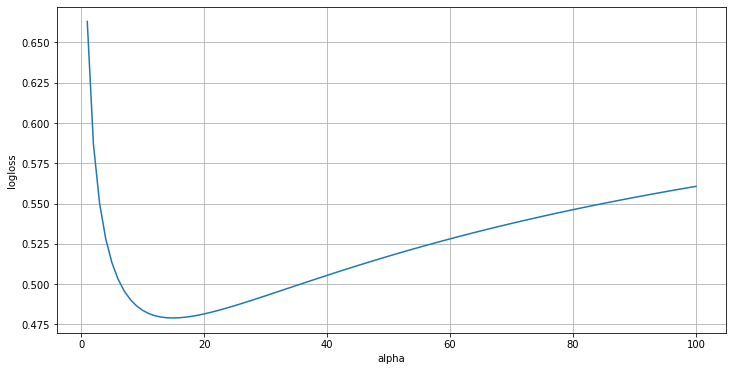

In [0]:
import matplotlib
results = pd.DataFrame()
# collect alpha list
results['alpha'] = gridsearch.cv_results_['param_alpha'].data
# collect test scores
results['neglogloss'] = gridsearch.cv_results_['mean_test_score'].data
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['alpha'], -results['neglogloss'])
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.grid()

In [0]:
print("Best parameter: ",gridsearch.best_params_)

Best parameter:  {'alpha': 15.0}


In [0]:
print("Best score: ",gridsearch.best_score_) 

Best score:  -0.47899609643730734


In [0]:
alpha_list2 = np.linspace(13, 18, 100)
parameter_grid2 = [{"alpha":alpha_list2}]
clf= MultinomialNB()
gridsearch2 = GridSearchCV(clf,parameter_grid2, scoring = 'neg_log_loss', cv = 5)
gridsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([13.        , 13.05050505, 13.1010101 , 13.15151515, 13.2020202 ,
       13.25252525, 13.3030303 , 13.35353535, 13.4040404 , 13.45454545,
       13.50505051, 13.55555556, 13.60606061, 13.65656566, 13.70707071,
       13.75757576, 13.80808081,...
       16.78787879, 16.83838384, 16.88888889, 16.93939394, 16.98989899,
       17.04040404, 17.09090909, 17.14141414, 17.19191919, 17.24242424,
       17.29292929, 17.34343434, 17.39393939, 17.44444444, 17.49494949,
       17.54545455, 17.5959596 , 17.64646465, 17.6969697 , 17.74747475,
       17.7979798 , 17.84848485, 17.8989899 , 17.94949495, 18.        ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

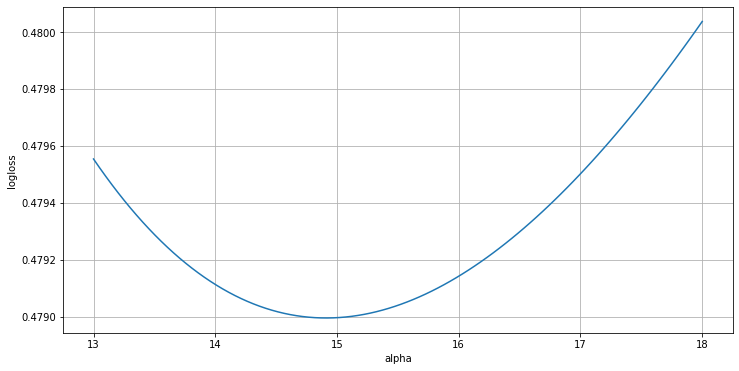

In [0]:
results2 = pd.DataFrame()
# collect alpha list
results2['alpha'] = gridsearch2.cv_results_['param_alpha'].data
# collect test scores
results2['neglogloss'] = gridsearch2.cv_results_['mean_test_score'].data
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results2['alpha'], -results2['neglogloss'])
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.grid()

In [0]:
print("Best parameter: ",gridsearch2.best_params_)

Best parameter:  {'alpha': 14.919191919191919}


In [0]:
print("Best score: ",gridsearch.best_score_) 

Best score:  -0.47899609643730734


In [0]:
clf= MultinomialNB(alpha=15.3)
clf.fit(X_train,y_train)

MultinomialNB(alpha=15.3, class_prior=None, fit_prior=True)

In [0]:
y_predictions = clf.predict(X_test)

In [0]:
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       845
           1       0.82      0.67      0.73       678

    accuracy                           0.78      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.78      0.78      1523



In [0]:
cf_matrix = confusion_matrix(y_test,y_predictions)
cf_matrix

array([[743, 102],
       [227, 451]])

In [0]:
accuracy_score(y_test,y_predictions)

0.7839789888378201

Now, let's test our model on our test data! First, we will apply the same cleaning process on the test set, just as we did on the train set


In [0]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
test_df['text'] = test_df['text'].apply(lambda x : remove_URL(x))
test_df['text'] = test_df["text"].apply(lambda x: remove_html(x))
test_df['text'] = test_df["text"].apply(lambda x: remove_emoji(x))
test_df['text'] = test_df["text"].apply(lambda x: remove_punctuation(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))

In [0]:
X_test =  count_vectorizer.transform(list(test_df['text']))
X_test = X_test.toarray()

In [0]:
y_predictions_test = clf.predict(X_test)

In [0]:
output = pd.DataFrame(test_df.id[:3263])
output['target'] = y_predictions_test

In [0]:
output.to_csv('nlp_countvectnaivebayes.csv', index=False)

**Kaggle score :**

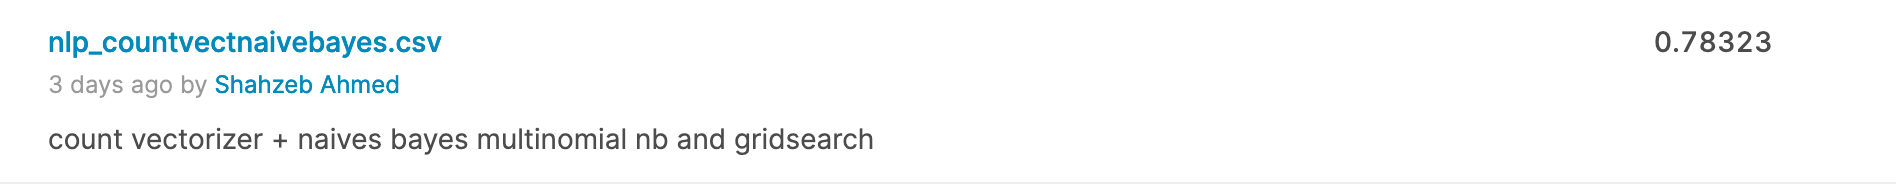

### 5.2 TFIDF and logistic regression

With the first technique we have an accuracy of **0.78323**. So now, let's look into a better approach for text processing to improve our score, an embedding technique called tf-idf and apply logistic regression on it.

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

In [0]:
X_tfidf_lr = train_df['text']
y_tfidf_lr = train_df['target']
X_train_tfidf_lr, X_test_tfidf_lr, y_train_tfidf_lr, y_test_tfidf_lr = train_test_split(X_tfidf_lr, y_tfidf_lr, test_size=0.2, random_state=113)

In [0]:
X_train_tfidf_lr = tfidf_vectorizer.fit_transform(X_train_tfidf_lr)

In [0]:
X_test_tfidf_lr = tfidf_vectorizer.transform(X_test_tfidf_lr)

In [0]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train_tfidf_lr,y_train_tfidf_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_predictions_tfidf_lr = clf_lr.predict(X_test_tfidf_lr)
print(classification_report(y_test_tfidf_lr,y_predictions_tfidf_lr))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       845
           1       0.84      0.68      0.75       678

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [0]:
cf_matrix_tfidf_lr = confusion_matrix(y_test_tfidf_lr,y_predictions_tfidf_lr)
cf_matrix_tfidf_lr

array([[756,  89],
       [217, 461]])

In [0]:
accuracy_score(y_test_tfidf_lr,y_predictions_tfidf_lr)

0.799080761654629

Let's test this model on the test dataset.

In [0]:
test_df_tfidf_lr = pd.read_csv("https://raw.githubusercontent.com/yassinhediger/fakenewsdetection/master/data/test.csv")

In [0]:
test_df_tfidf_lr['text'] = test_df_tfidf_lr['text'].apply(lambda x : remove_URL(x))
test_df_tfidf_lr['text'] = test_df_tfidf_lr["text"].apply(lambda x: remove_html(x))
test_df_tfidf_lr['text'] = test_df_tfidf_lr["text"].apply(lambda x: remove_emoji(x))
test_df_tfidf_lr['text'] = test_df_tfidf_lr["text"].apply(lambda x: remove_punctuation(x))
test_df_tfidf_lr['text'] = test_df_tfidf_lr['text'].apply(lambda x : clean_text(x))

In [0]:
X_test_tfidf_lr =  tfidf_vectorizer.transform(list(test_df_tfidf_lr['text']))
X_test_tfidf_lr = X_test_tfidf_lr.toarray()

In [0]:
predictions_tfidf_lr = clf_lr.predict(X_test_tfidf_lr)

In [0]:
output = pd.DataFrame(test_df_tfidf_lr.id[:3263])
output['target'] = predictions_tfidf_lr

In [0]:
output.to_csv('nlp_tfidf_logisticregression.csv', index=False)

**Kaggle score :** 

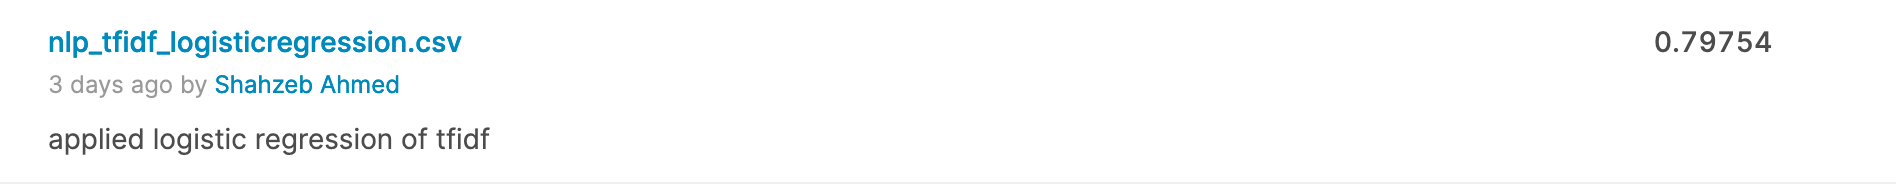

### 5.3 TFIDF and multinomialNB

As we can see we increase a little bit our accuracy (**0.79754**). Now, let's look into another way to improve our accuracy, an embedding technique called tf-idf. 

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

In [0]:
X_tfidf = train_df['text']
y_tfidf = train_df['target']
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=113)

In [0]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tfidf)

In [0]:
X_test_tfidf = tfidf_vectorizer.transform(X_test_tfidf)

In [0]:
alpha_list_tfidf =  np.linspace(0.001, 2, 100)
parameter_grid1 = [{"alpha":alpha_list_tfidf}]
clf_mnb = MultinomialNB()
gridsearch1 = GridSearchCV(clf_mnb,parameter_grid1, scoring = 'neg_log_loss', cv = 5)
gridsearch1.fit(X_train_tfidf, y_train_tfidf)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-03, 2.11919192e-02, 4.13838384e-02, 6.15757576e-02,
       8.17676768e-02, 1.01959596e-01, 1.22151515e-01, 1.42343434e-01,
       1.62535354e-01, 1.82727273e-01, 2.02919192e-01, 2.23111111e-01,
       2.43303030e-...
       1.61635354e+00, 1.63654545e+00, 1.65673737e+00, 1.67692929e+00,
       1.69712121e+00, 1.71731313e+00, 1.73750505e+00, 1.75769697e+00,
       1.77788889e+00, 1.79808081e+00, 1.81827273e+00, 1.83846465e+00,
       1.85865657e+00, 1.87884848e+00, 1.89904040e+00, 1.91923232e+00,
       1.93942424e+00, 1.95961616e+00, 1.97980808e+00, 2.00000000e+00])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

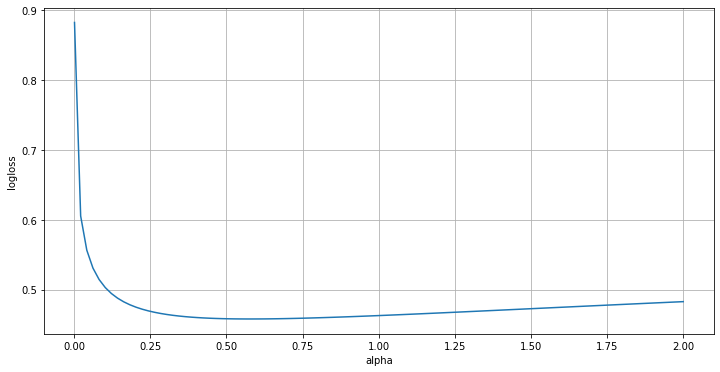

In [0]:
results_tfidf = pd.DataFrame()
# collect alpha list
results_tfidf['alpha'] = gridsearch1.cv_results_['param_alpha'].data
# collect test scores
results_tfidf['neglogloss'] = gridsearch1.cv_results_['mean_test_score'].data
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results_tfidf['alpha'], -results_tfidf['neglogloss'])
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.grid()

In [0]:
alpha_list_tfidf2 =  np.linspace(0.2, 1, 100)
parameter_grid2 = [{"alpha":alpha_list_tfidf2}]
clf_mnb = MultinomialNB()
gridsearch2 = GridSearchCV(clf,parameter_grid2, scoring = 'neg_log_loss', cv = 5)
gridsearch2.fit(X_train_tfidf, y_train_tfidf)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=15.3, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([0.2       , 0.20808081, 0.21616162, 0.22424242, 0.23232323,
       0.24040404, 0.24848485, 0.25656566, 0.26464646, 0.27272727,
       0.28080808, 0.28888889, 0.2969697 , 0.30505051, 0.31313131,
       0.32121212, 0.32929293, 0.33737374, 0...
       0.80606061, 0.81414141, 0.82222222, 0.83030303, 0.83838384,
       0.84646465, 0.85454545, 0.86262626, 0.87070707, 0.87878788,
       0.88686869, 0.89494949, 0.9030303 , 0.91111111, 0.91919192,
       0.92727273, 0.93535354, 0.94343434, 0.95151515, 0.95959596,
       0.96767677, 0.97575758, 0.98383838, 0.99191919, 1.        ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

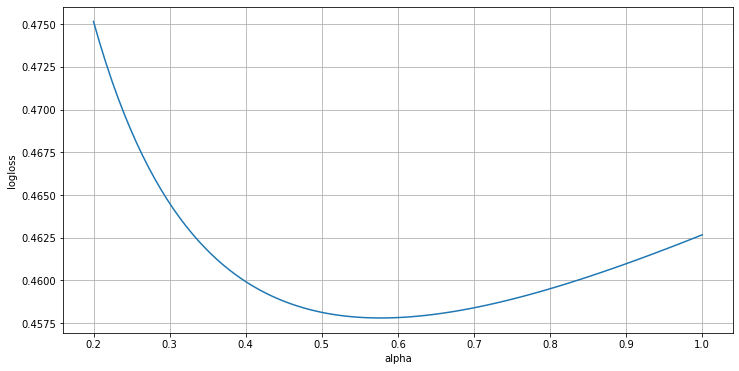

In [0]:
results_tfidf2 = pd.DataFrame()
# collect alpha list
results_tfidf2['alpha'] = gridsearch2.cv_results_['param_alpha'].data
# collect test scores
results_tfidf2['neglogloss'] = gridsearch2.cv_results_['mean_test_score'].data
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results_tfidf2['alpha'], -results_tfidf2['neglogloss'])
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.grid()

In [0]:
print("Best score: ",gridsearch2.best_score_) 

Best score:  -0.45780182687484733


In [0]:
print("Best parameter: ",gridsearch2.best_params_)

Best parameter:  {'alpha': 0.5797979797979798}


In [0]:
clf_mnb = MultinomialNB(alpha=0.57)
clf_mnb.fit(X_train_tfidf,y_train_tfidf)

MultinomialNB(alpha=0.57, class_prior=None, fit_prior=True)

In [0]:
y_predictions_tfidf = clf_mnb.predict(X_test_tfidf)
print(classification_report(y_test_tfidf,y_predictions_tfidf))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       845
           1       0.81      0.68      0.74       678

    accuracy                           0.78      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.78      0.78      1523



In [0]:
cf_matrix_tfidf = confusion_matrix(y_test_tfidf,y_predictions_tfidf)
cf_matrix_tfidf

array([[735, 110],
       [220, 458]])

In [0]:
accuracy_score(y_test_tfidf,y_predictions_tfidf)

0.783322390019698

Let's test this model on the test dataset.

In [0]:
test_df_tfidf = pd.read_csv("https://raw.githubusercontent.com/yassinhediger/fakenewsdetection/master/data/test.csv")

In [0]:
test_df_tfidf['text'] = test_df_tfidf['text'].apply(lambda x : remove_URL(x))
test_df_tfidf['text'] = test_df_tfidf["text"].apply(lambda x: remove_html(x))
test_df_tfidf['text'] = test_df_tfidf["text"].apply(lambda x: remove_emoji(x))
test_df_tfidf['text'] = test_df_tfidf["text"].apply(lambda x: remove_punctuation(x))
test_df_tfidf['text'] = test_df_tfidf['text'].apply(lambda x : clean_text(x))

In [0]:
X_test_tfidf =  tfidf_vectorizer.transform(list(test_df_tfidf['text']))
X_test_tfidf = X_test_tfidf.toarray()

In [0]:
predictions_tfidf = clf_mnb.predict(X_test_tfidf)

In [0]:
output = pd.DataFrame(test_df_tfidf.id[:3263])
output['target'] = predictions_tfidf

In [0]:
output.to_csv('nlp_tfidf_multinomial.csv', index=False)

**Kaggle score :**

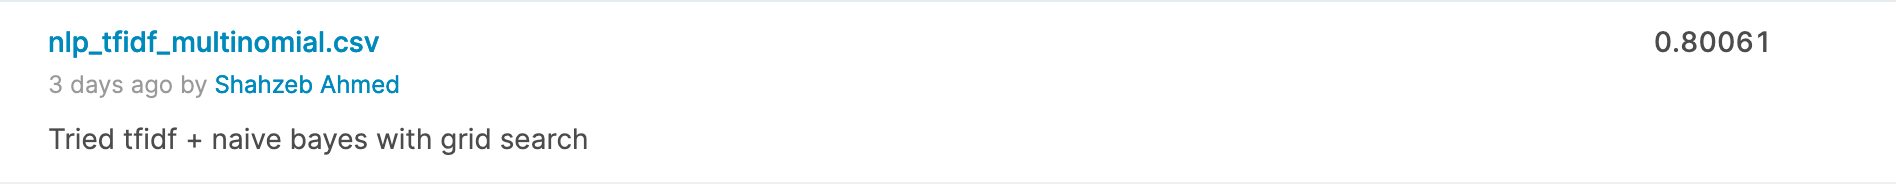

### 5.4 Bag of words and logistic regression

Let's try another technique to improve our current score of **0.80061**.  In this section we are going to apply the logistic regression on the count vectorizer.

In [0]:
count_vectorizer = CountVectorizer(lowercase=True,stop_words='english',max_df=0.95,min_df=2)
X_cv_lr = count_vectorizer.fit_transform(list(train_df['text']))
X_cv_lr = X_cv_lr.toarray()
y_cv_lr = train_df['target']

In [0]:
X_train_cvlr, X_test_cvlr, y_train_cvlr, y_test_cvlr = train_test_split(X_cv_lr, y_cv_lr, test_size=0.2, random_state=113)

In [0]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train_cvlr,y_train_cvlr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_predictions_cvlr = clf_lr.predict(X_test_cvlr)

In [0]:
print(classification_report(y_test_cvlr,y_predictions_cvlr))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       845
           1       0.80      0.69      0.74       678

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [0]:
cf_matrix_cvlr = confusion_matrix(y_test_cvlr,y_predictions_cvlr)
cf_matrix_cvlr

array([[731, 114],
       [208, 470]])

In [0]:
accuracy_score(y_test_cvlr,y_predictions_cvlr)

0.788575180564675

Let's test our model on the test dataset.

In [0]:
test_df_cvlr = pd.read_csv("https://raw.githubusercontent.com/yassinhediger/fakenewsdetection/master/data/test.csv")

In [0]:
test_df_cvlr['text'] = test_df_cvlr['text'].apply(lambda x : remove_URL(x))
test_df_cvlr['text'] = test_df_cvlr["text"].apply(lambda x: remove_html(x))
test_df_cvlr['text'] = test_df_cvlr["text"].apply(lambda x: remove_emoji(x))
test_df_cvlr['text'] = test_df_cvlr["text"].apply(lambda x: remove_punctuation(x))
test_df_cvlr['text'] = test_df_cvlr['text'].apply(lambda x : clean_text(x))

In [0]:
X_test_cvlr =  count_vectorizer.transform(list(test_df_cvlr['text']))
X_test_cvlr = X_test_cvlr.toarray()

In [0]:
predictions_cvlr = clf_lr.predict(X_test_cvlr)

In [0]:
output = pd.DataFrame(test_df_cvlr.id[:3263])
output['target'] = predictions_cvlr

In [0]:
output.to_csv('nlp_countvect_logisticregression.csv', index=False)

**Kaggle score :**

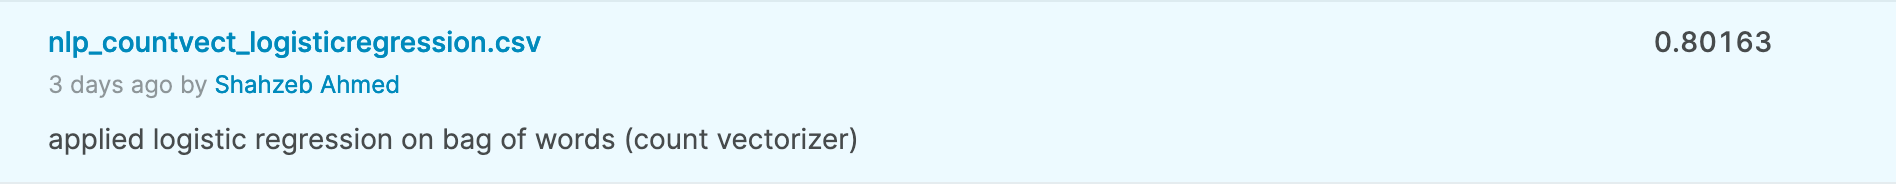

### 5.5 Word2Vec

Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.

In [0]:
import gensim
#we need to import the googlenewsvectornegative300 data in to our notebook in
#order to be able to use the pretrained model.
#the data can be found on kaggle and can be run on kaggle also 
word2vec_path = "../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [0]:
#we have to tokenize our text inputs
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

train_df["tokens"] = train_df["text"].apply(tokenizer.tokenize)
train_df.head()

In [0]:
#initialize our functions
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, train_df, generate_missing=False):
    embeddings = train_df['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [0]:
#then we do a train test split
embeddings = get_word2vec_embeddings(word2vec, train_df)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, train_df["target"],
                                                                                        test_size=0.2, random_state=40)

In [0]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

In [0]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, train_df["target"])
plt.show()

In [0]:
#we fit the classifier on our train data
clf_w2v = LogisticRegression(C=1, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)

In [0]:
#then we do the predictions on our test data
y_predictions_word2vec = clf_w2v.predict(X_test_word2vec)
print(classification_report(y_test_word2vec,y_predictions_word2vec))

In [0]:
accuracy_score(y_test_word2vec,y_predictions_word2vec)

With this model we have an accuray of **0.797** so we didn't test the model on the test dataset because it's approximately the same accuracy as the model of 5.2 .

### 5.6 Bert Model
To further increase our accuracy we tried a last model which is called Bert, a technique for NLP pre-training developed by Google. 

Thanks to : https://www.kaggle.com/chariots17/using-bert-model-and-naive-bayes/execution

To run this model we need patience/time and anaconda/jupiter, it doesn't work. on google collab 

In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
pip install bert-for-tf2

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub


from bert import bert_tokenization

In [0]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 13.1 s, sys: 2.18 s, total: 15.2 s
Wall time: 15 s


In [0]:
# Load tokenizer from the bert layer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
train_input = bert_encode(train_df.text.values, tokenizer, max_len=160)
test_input = bert_encode(test_df.text.values, tokenizer, max_len=160)
train_labels = train_df.target.values

In [0]:
model_bert = build_model(bert_layer, max_len=160)
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
train_history = model_bert.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=8
)

model_bert.save('model_bert.h5')

Epoch 1/3


In [0]:
# Prediction by BERT model 
model_bert.load_weights('model_bert.h5')
test_pred_bert = model_bert.predict(test_input)
test_pred_bert_int = test_pred_bert.round().astype('int')

In [0]:
# Prediction by BERT model for the Confusion Matrix
train_pred_bert = model_bert.predict(train_input)
train_pred_bert_int = train_pred_bert.round().astype('int')

In [0]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)


In [0]:
# Showing Confusion Matrix for BERT model
plot_cm(train_pred_bert_int, train['target'].values, 'Confusion matrix for BERT model', figsize=(7,7))

**Kaggle score :**

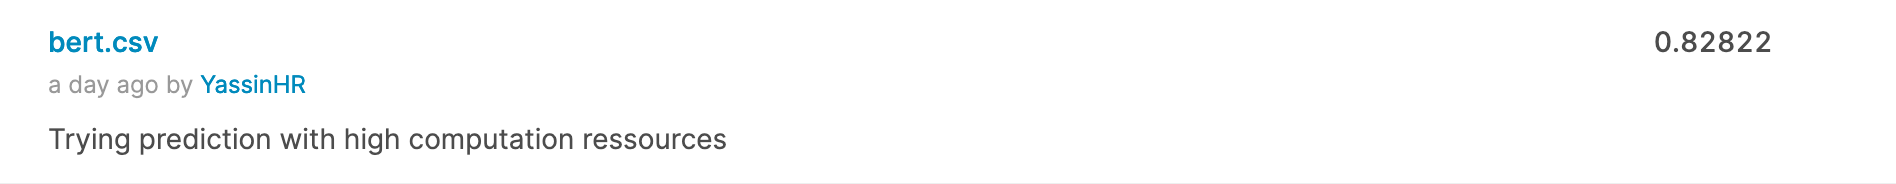